In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img = cv.imread('test_imgs/ISIC_0000264.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
label = cv.imread('test_imgs/ISIC_0000264_segmentation.png', cv.IMREAD_GRAYSCALE)

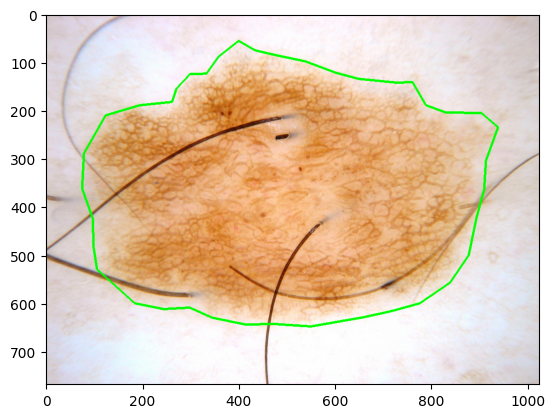

In [4]:
def draw_contours(img, label):
  img_out = img.copy()
  contours, hierarchy = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  img_out = cv.drawContours(img_out, contours, -1, (0, 255, 0), 3)
  return img_out

plt.imshow(draw_contours(img, label))

(0.0, 1024.0, 768.0, 0.0)

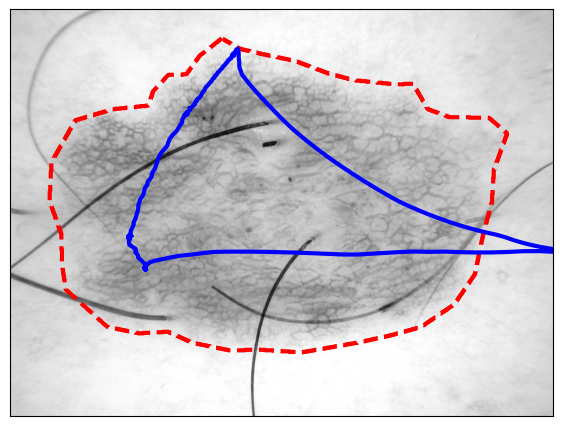

In [5]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.color import rgb2gray

# initial contour based on image label
contours, hierarchy = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = contours[0].squeeze()

img_ = rgb2gray(img)
init = np.array([contour[:, 0], contour[:, 1]]).T
snake = active_contour(gaussian(img_, 3), init, alpha=0.01, beta=10,  gamma=0.001, w_line=-5, w_edge=0, max_num_iter=5000)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_.shape[1], img_.shape[0], 0])

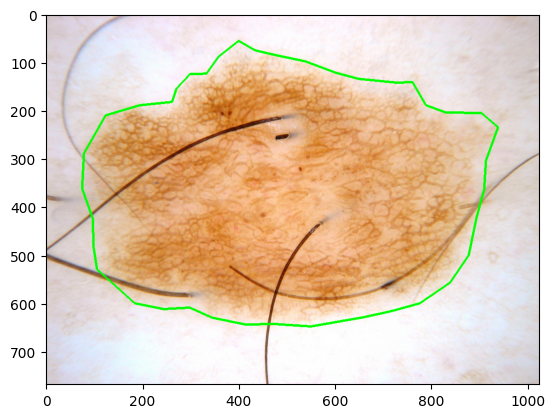

In [6]:
# grabcut

# initial mask based on label
mask = np.zeros(img.shape[:2], np.uint8)
mask[label == 255] = 1
mask[label == 0] = 0

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# run grabcut
mask, bgdModel, fgdModel = cv.grabCut(img, mask, None, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_MASK)

plt.imshow(draw_contours(img, mask))

/tmp/ipykernel_3579706/2487291051.py:7: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.22. Set `channel_axis=-1` explicitly to silence this warning.
  img_sobel_blur = gaussian(img_sobel, 3)


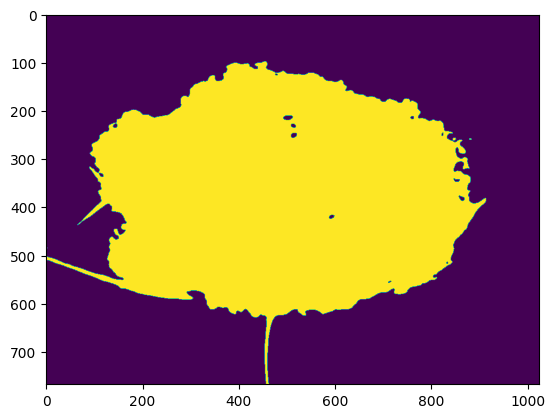

In [7]:
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu

img_sobel = sobel(img)
img_sobel_blur = gaussian(img_sobel, 3)
# otsu threshold img_sobel_blur
thresh = threshold_otsu(rgb2gray(img_sobel_blur))

img_plot = np.zeros_like(rgb2gray(img_sobel_blur))
img_plot[rgb2gray(img_sobel_blur) > thresh] = 1

plt.imshow(img_plot)

# plt.imshow(img_sobel_blur > thresh)
# plt.show()

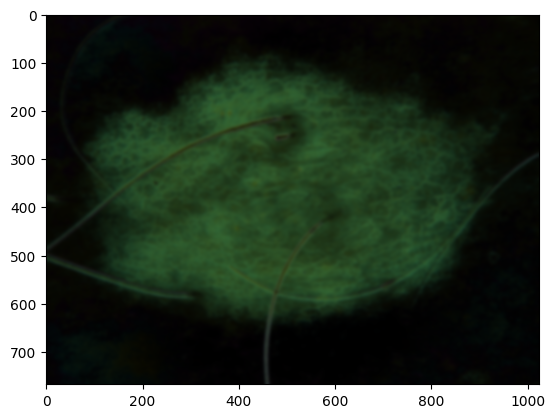

In [8]:
plt.imshow(img_sobel_blur)

(0.0, 1024.0, 768.0, 0.0)

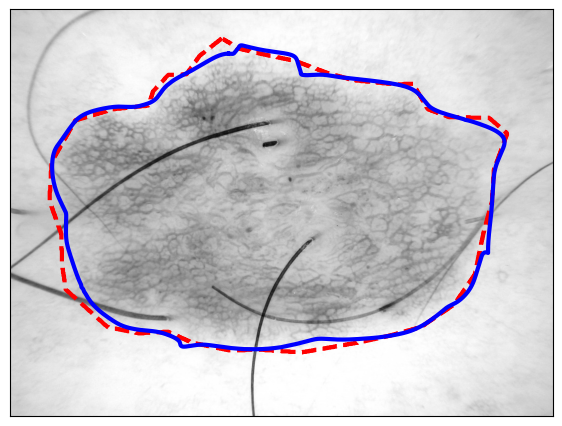

In [9]:
# initial contour based on image label
contours, hierarchy = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = contours[0].squeeze()

init = np.array([contour[:, 0], contour[:, 1]]).T
snake = active_contour(1 - img_sobel_blur, init, alpha=0.01, beta=1, w_line=-1, w_edge=0, gamma=0.005, max_num_iter=30)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_.shape[1], img_.shape[0], 0])

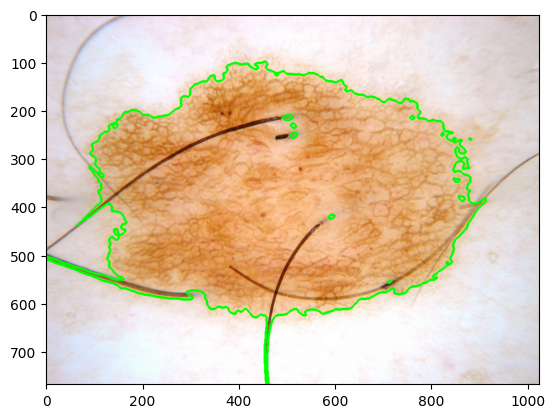

In [10]:
contour_img = img_plot.astype(np.uint8)
# find contours
contours, hierarchy = cv.findContours(contour_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# simply contour
contour = contours[0].squeeze()
# approximated contour
epsilon = 0.01 * cv.arcLength(contour, True)
approx = cv.approxPolyDP(contour, epsilon, True)

# draw contours
img_out = img.copy()
img_out = cv.drawContours(img_out, contours, -1, (0, 255, 0), 3)

plt.imshow(img_out)

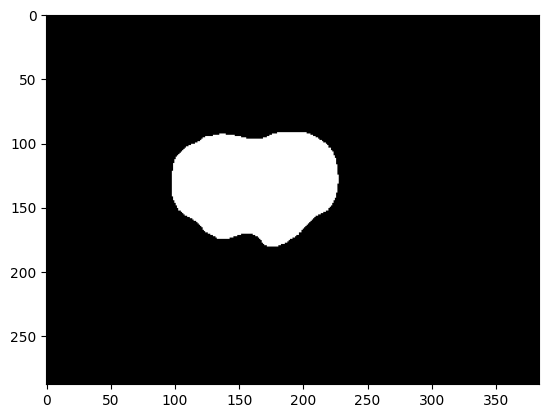

In [11]:
img = cv.imread('test_imgs/30.tif')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

2  labels  {0, 1}
Using generic 2D functions


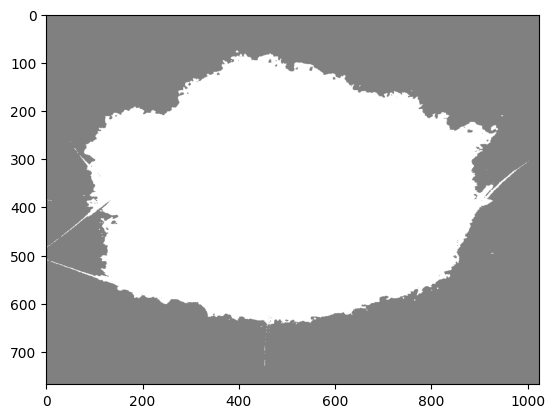

In [12]:
import sys
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian

fn_im = 'test_imgs/ISIC_0000264.jpg'
fn_anno = 'test_imgs/ISIC_0000264_segmentation.png'

img = cv.imread(fn_im)

# Convert the annotation's RGB color to a single 32-bit integer color 0xBBGGRR
anno_rgb = cv.imread(fn_anno)
anno_rgb[anno_rgb == 0] = 128
anno_rgb = anno_rgb.astype(np.uint32)
anno_lbl = anno_rgb[:,:,0] + (anno_rgb[:,:,1] << 8) + (anno_rgb[:,:,2] << 16)

# Convert the 32bit integer color to 1, 2, ... labels.
# Note that all-black, i.e. the value 0 for background will stay 0.
colors, labels = np.unique(anno_lbl, return_inverse=True)

# But remove the all-0 black, that won't exist in the MAP!
HAS_UNK = 0 in colors
if HAS_UNK:
    print("Found a full-black pixel in annotation image, assuming it means 'unknown' label, and will thus not be present in the output!")
    print("If 0 is an actual label for you, consider writing your own code, or simply giving your labels only non-zero values.")
    colors = colors[1:]
#else:
#    print("No single full-black pixel found in annotation image. Assuming there's no 'unknown' label!")

# And create a mapping back from the labels to 32bit integer colors.
colorize = np.empty((len(colors), 3), np.uint8)
colorize[:,0] = (colors & 0x0000FF)
colorize[:,1] = (colors & 0x00FF00) >> 8
colorize[:,2] = (colors & 0xFF0000) >> 16

# Compute the number of classes in the label image.
# We subtract one because the number shouldn't include the value 0 which stands
# for "unknown" or "unsure".
n_labels = len(set(labels.flat)) - int(HAS_UNK)
print(n_labels, " labels", (" plus \"unknown\" 0: " if HAS_UNK else ""), set(labels.flat))

###########################
### Setup the CRF model ###
###########################
use_2d = False
# use_2d = True
if use_2d:
    print("Using 2D specialized functions")

    # Example using the DenseCRF2D code
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=HAS_UNK)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
else:
    print("Using generic 2D functions")

    # Example using the DenseCRF class and the util functions
    d = dcrf.DenseCRF(img.shape[1] * img.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=HAS_UNK)
    d.setUnaryEnergy(U)

    # This creates the color-independent features and then add them to the CRF
    feats = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=3,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This creates the color-dependent features and then add them to the CRF
    feats = create_pairwise_bilateral(sdims=(80, 80), schan=(13, 13, 13),
                                      img=img, chdim=2)
    d.addPairwiseEnergy(feats, compat=10,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)


####################################
### Do inference and compute MAP ###
####################################

Q = d.inference(300)

# Find out the most probable class for each pixel.
MAP = np.argmax(Q, axis=0)

# Convert the MAP (labels) back to the corresponding colors and save the image.
# Note that there is no "unknown" here anymore, no matter what we had at first.
MAP = colorize[MAP,:]
plt.imshow(MAP.reshape(img.shape))

# # Just randomly manually run inference iterations
# Q, tmp1, tmp2 = d.startInference()
# for i in range(5):
#     print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
#     d.stepInference(Q, tmp1, tmp2)

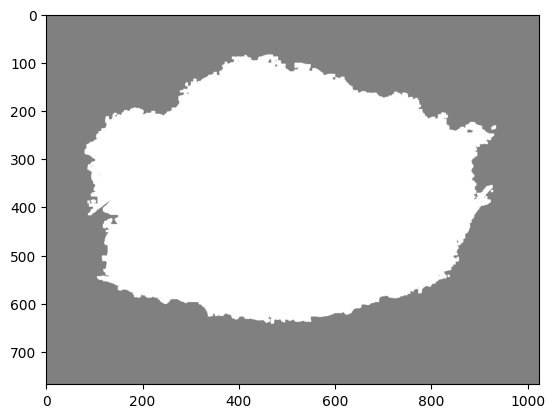

In [13]:
out_img = MAP.reshape(img.shape)

# morphological operations
kernel = np.ones((5, 5), np.uint8)
out_img = cv.erode(out_img, kernel, iterations=1)
out_img = cv.dilate(out_img, kernel, iterations=1)

plt.imshow(out_img)

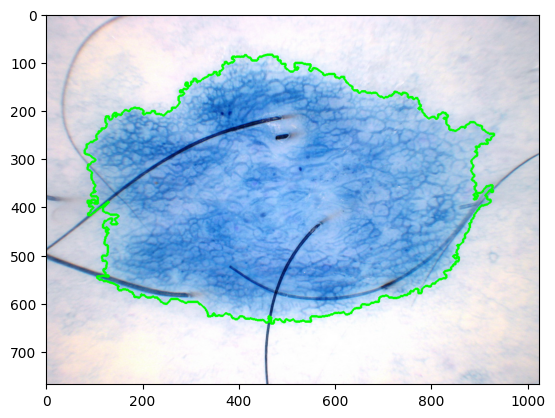

In [14]:
# find contour
img_out_cv = out_img[:, :, 0].astype(np.uint8)
img_out_cv[img_out_cv == 255] = 1
img_out_cv[img_out_cv == 128] = 0
contours, hierarchy = cv.findContours(img_out_cv, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = contours[0].squeeze()

# approximated contour
epsilon = 0.01 * cv.arcLength(contour, True)
approx = cv.approxPolyDP(contour, epsilon, True)

# draw contours
img_plot = cv.imread(fn_im)
# get largest contour
contour = max(contours, key=cv.contourArea)
contours = [contour]

img_plot = cv.drawContours(img_plot, contours, -1, (0, 255, 0), 3)

plt.imshow(img_plot)

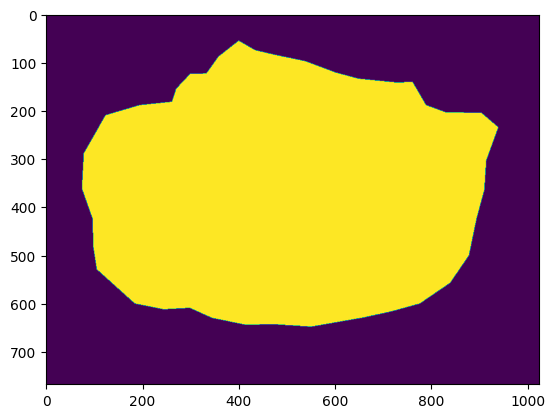

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

fn_im = 'test_imgs/ISIC_0000264.jpg'
fn_anno = 'test_imgs/ISIC_0000264_segmentation.png'

label = cv.imread(fn_anno, cv.IMREAD_GRAYSCALE)
plt.imshow(label)

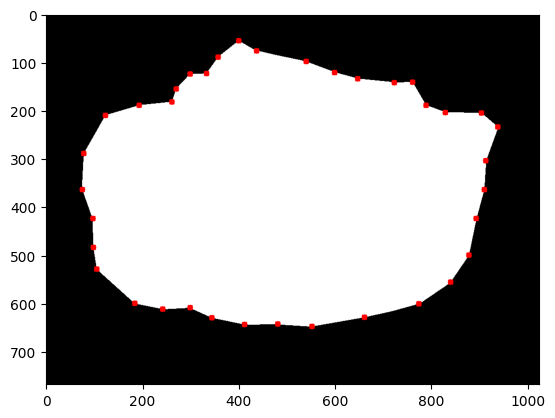

In [16]:
# get polygon points
contours, hierarchy = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = contours[0].squeeze()

# simplify contour
epsilon = 0.001 * cv.arcLength(contour, True)
approx = cv.approxPolyDP(contour, epsilon, True)

# get polygon points
points = []
for point in approx:
  points.append(point[0])
points = np.array(points)

# draw polygon points
img_plot = label.copy()
# to rgb
img_plot = cv.cvtColor(img_plot, cv.COLOR_GRAY2RGB)
for point in points:
  img_plot = cv.circle(img_plot, tuple(point), 1, (255, 0, 0), 10)

plt.imshow(img_plot)

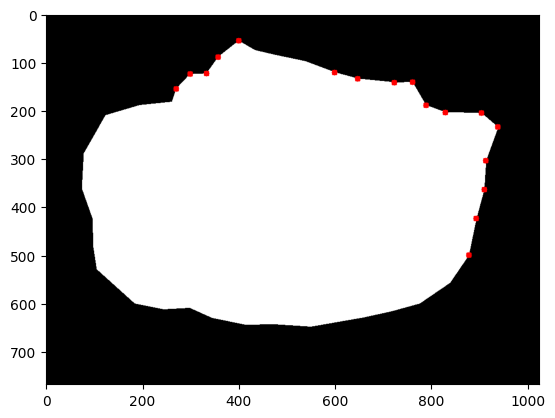

In [17]:
# randomly select groups of 5 consecutive points
n = 5
groups = []
for i in range(0, len(points) - n + 1):
  groups.append(points[i:i + n])

# sample 5 groups
n_groups = 5
groups = np.array(groups)
idx = np.random.randint(len(groups), size=5)
groups = groups[idx]

# draw groups
img_plot = label.copy()
# to rgb
img_plot = cv.cvtColor(img_plot, cv.COLOR_GRAY2RGB)
for group in groups:
  for point in group:
    img_plot = cv.circle(img_plot, tuple(point), 1, (255, 0, 0), 10)

plt.imshow(img_plot)


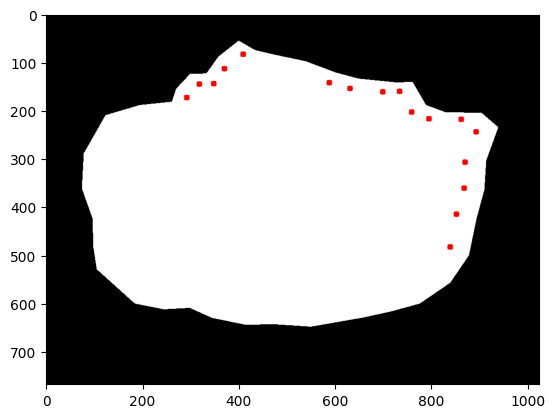

In [18]:
# pull group points towards centroid

# get centroid
centroid = np.mean(points, axis=0)

pull_strength = 0.1

# pull points towards centroid
for group in groups:
  for point in group:
    point[0] = point[0] + pull_strength * (centroid[0] - point[0])
    point[1] = point[1] + pull_strength * (centroid[1] - point[1])


# draw groups
img_plot = label.copy()
# to rgb
img_plot = cv.cvtColor(img_plot, cv.COLOR_GRAY2RGB)
for group in groups:
  for point in group:
    # make pull strength proportional to distance from centroid
    pull_str_point = pull_strength * np.linalg.norm(centroid - point)
    img_plot = cv.circle(img_plot, tuple(point), 1, (255, 0, 0), 10)

plt.imshow(img_plot)

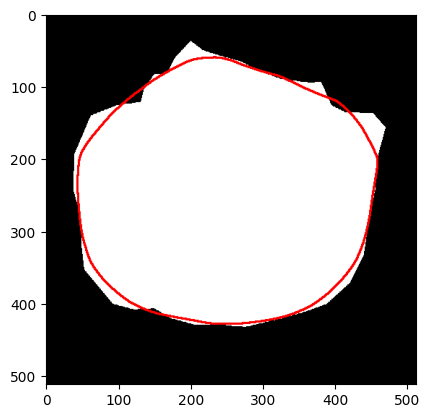

In [19]:
label = cv.imread(fn_anno, cv.IMREAD_GRAYSCALE)
label = cv.resize(label, (512, 512), interpolation=cv.INTER_NEAREST)

# simplify label
label_blur = cv.blur(label, (128, 128))

th = 128
thresh = cv.threshold(label_blur, th, 255, cv.THRESH_BINARY)[1]

thresh_contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# draw contour on label
label_contour = label.copy()
label_contour = cv.cvtColor(label_contour, cv.COLOR_GRAY2RGB)
label_contour = cv.drawContours(label_contour, thresh_contours, -1, (255, 0, 0), 2)

plt.imshow(label_contour)

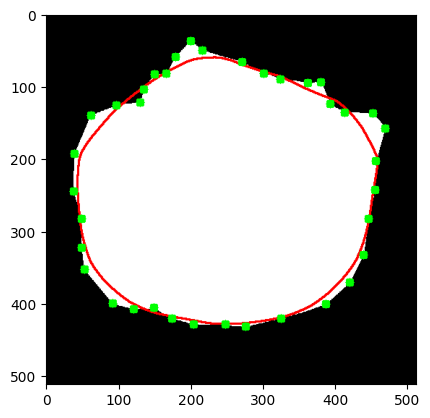

In [20]:
# original contour points
contours, hierarchy = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = contours[0].squeeze()

# simplify contour
epsilon = 0.001 * cv.arcLength(contour, True)
approx = cv.approxPolyDP(contour, epsilon, True)

# get polygon points
points = []
for point in approx:
  points.append(point[0])
points = np.array(points)

for point in points:
  label_contour = cv.circle(label_contour, tuple(point), 1, (0, 255, 0), 10)

plt.imshow(label_contour)

label area:  126373
new label area:  81447


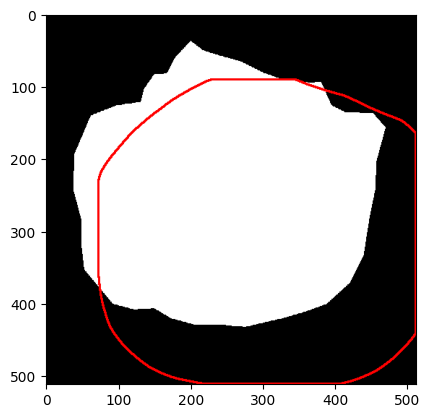

In [21]:
# max distance between thresholded contour and original contour
max_dist = 0
for point in points:
  point = point.astype(float)
  dist = cv.pointPolygonTest(thresh_contours[0], tuple(point), True)
  dist = abs(dist)
  if dist > max_dist:
    max_dist = dist


kernel = np.ones((int(max_dist) * 2, int(max_dist) * 2), np.uint8)
thresh_initial = cv.erode(thresh, kernel, iterations=1)
thresh_current = thresh_initial.copy()

new_label_area_ratio = 1.3 # how many times larger the new label area is compared to the original label area

label_area = np.sum(label == 255)
print('label area: ', label_area)
new_label_area = np.sum(thresh_current == 255)
print('new label area: ', new_label_area)

step_size = max_dist * 0.1
while True:
  # dilate thresholded contour
  kernel = np.ones((int(step_size), int(step_size)), np.uint8)
  thresh_current = cv.dilate(thresh_current, kernel, iterations=1)

  new_label_area = np.sum(thresh_current == 255)
  # check if new label area is larger than original label area
  if new_label_area >= label_area * new_label_area_ratio:
    break

new_contour, _ = cv.findContours(thresh_current, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img_plot = label.copy()
img_plot = cv.cvtColor(img_plot, cv.COLOR_GRAY2RGB)
img_plot = cv.drawContours(img_plot, new_contour, -1, (255, 0, 0), 2)

plt.imshow(img_plot)

step size:  2.8178005607210745


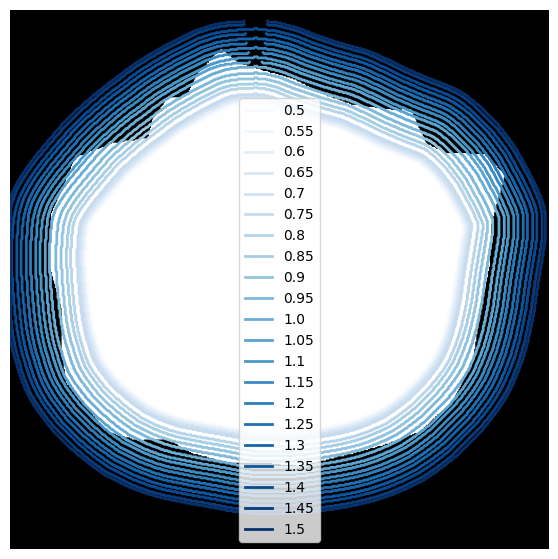

In [75]:
def get_simplified_label(label):
  # blur
  label_blur = cv.blur(label, (128, 128))
  # threshold
  thresh = cv.threshold(label_blur, 128, 255, cv.THRESH_BINARY)[1]
  return thresh

def get_max_distance(label1, label2):
  # get contours
  contours1, _ = cv.findContours(label1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  contours2, _ = cv.findContours(label2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  # get contour points
  contour1 = contours1[0].squeeze()
  contour2 = contours2[0].squeeze()
  # get max distance
  max_dist = 0
  for point in contour1:
    point = point.astype(float)
    dist = cv.pointPolygonTest(contour2, tuple(point), True)
    dist = abs(dist)
    if dist > max_dist:
      max_dist = dist
  return max_dist

def get_initial_label_for_dilation(label, max_dist):
  kernel = np.ones((int(max_dist) * 2, int(max_dist) * 2), np.uint8)
  return cv.erode(label, kernel, iterations=1)

ratios = np.arange(0.5, 1.51, 0.05)

label = cv.imread(fn_anno, cv.IMREAD_GRAYSCALE)
label = cv.resize(label, (512, 512), interpolation=cv.INTER_NEAREST)

step_size = max_dist * 0.1
simplified_label = get_simplified_label(label)
max_dist = get_max_distance(label, simplified_label)
current_label = get_initial_label_for_dilation(simplified_label, max_dist)
original_label_area = np.sum(label == 255)

labels_for_ratios = []
step_size = max_dist * 0.1
print('step size: ', step_size)

current_kernel_size = -max_dist * 2
kernel_step_size = round(max_dist * 0.1)

for ratio in ratios:
  while True:
    kernel_size = abs(int(round(current_kernel_size)))
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))
    if current_kernel_size < 0:
      current_label = cv.erode(simplified_label, kernel, iterations=1)
    elif current_kernel_size > 0:
      current_label = cv.dilate(simplified_label, kernel, iterations=1)

    current_kernel_size += kernel_step_size

    new_label_area = np.sum(current_label == 255)
    # check if new label area is larger than original label area
    if new_label_area >= original_label_area * ratio:
      break
  
  labels_for_ratios.append(current_label.copy())

# ratio colors for plotting
colors = plt.cm.Blues(np.linspace(0, 1, len(ratios)))

# plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(label, cmap=plt.cm.gray)
for i, ratio in enumerate(ratios):
  contours, _ = cv.findContours(labels_for_ratios[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  contour = contours[0].squeeze()
  ax.plot(contour[:, 0], contour[:, 1], color=colors[i], linewidth=2, label=round(ratio, 2))
ax.legend()
ax.axis('off')
plt.show()

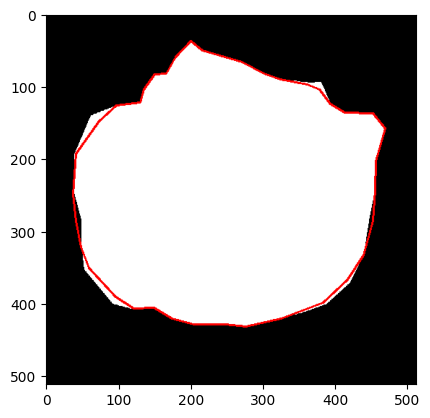

In [87]:
# original contour points
contours, hierarchy = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = contours[0].squeeze()

# simplify contour
epsilon = 0.001 * cv.arcLength(contour, True)
approx = cv.approxPolyDP(contour, epsilon, True)

# get polygon points
points = []
for point in approx:
  points.append(point[0])
points = np.array(points)

contours, _ = cv.findContours(labels_for_ratios[10], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
label_contour = cv.cvtColor(label, cv.COLOR_GRAY2RGB)
label_contour = cv.drawContours(label_contour, contours, -1, (255, 0, 0), 2)

point_above_contour = np.zeros(len(points))

# draw result
for i, point in enumerate(points):
  if is_inside_contour(point, contours):
    label_contour = cv.circle(label_contour, tuple(point), 1, (0, 0, 255), 10)
    point_above_contour[i] = 1
  else:
    label_contour = cv.circle(label_contour, tuple(point), 1, (0, 255, 0), 10)
    point_above_contour[i] = 0

# label points as groups of 1s or 0s
point_groups = []
group = []
for i, point in enumerate(points):
  if i == 0:
    group.append(point)
  else:
    if point_above_contour[i] == point_above_contour[i - 1]:
      group.append(point)
    else:
      point_groups.append(group)
      group = [point]

group_colors = plt.cm.tab10(np.linspace(0, 1, len(point_groups)))
for i, group in enumerate(point_groups):
  for point in group:
    c = (group_colors[i] * 255)[:3]
    c = (int(c[0]), int(c[1]), int(c[2]))
    label_contour = cv.circle(label_contour, tuple(point), 1, c, 10)

random_group_idxs = np.random.randint(len(point_groups), size=5)

# assign points to closest point on contour
new_points = np.array(points)
for i, point in enumerate(points):
  # check if point is in random group
  in_group = False
  for group_idx in random_group_idxs:
    if np.sum(point == point_groups[group_idx]) > 0:
      in_group = True
      break

  if in_group:
    # get closest point on error contour
    closest_point = None
    min_dist = float('inf')
    for contour in contours:
      for contour_point in contour:
        dist = np.linalg.norm(contour_point - point)
        if dist < min_dist:
          min_dist = dist
          closest_point = contour_point
    new_points[i] = closest_point

# draw result
label_contour = cv.cvtColor(label, cv.COLOR_GRAY2RGB)
#for point in new_points:
#  label_contour = cv.circle(label_contour, tuple(point), 1, (0, 255, 0), 10)

# draw contour from new_points
contour = np.array([new_points], dtype=np.int32)
label_contour = cv.drawContours(label_contour, contour, -1, (255, 0, 0), 2)

plt.imshow(label_contour)

[200  37]
[193  44]
[193  45]
[192  46]
[191  46]
[191  47]
[190  48]
[189  48]
[189  49]
[188  50]
[187  50]
[187  51]
[179  59]
[179  60]
[177  62]
[177  63]
[176  64]
[176  65]
[175  66]
[175  67]
[174  68]
[174  69]
[173  70]
[173  71]
[172  72]
[172  73]
[171  74]
[171  75]
[170  76]
[170  77]
[169  78]
[169  79]
[166  82]
[163  82]
[162  83]
[150  83]
[147  86]
[147  87]
[146  88]
[146  89]
[143  92]
[143  93]
[140  96]
[140  97]
[139  98]
[139  99]
[136 102]
[136 103]
[135 104]
[135 107]
[134 108]
[134 111]
[133 112]
[133 115]
[132 116]
[132 119]
[131 120]
[131 121]
[130 122]
[124 122]
[123 123]
[119 123]
[118 124]
[109 124]
[108 125]
[105 125]
[104 126]
[ 97 126]
[ 96 127]
[ 95 127]
[ 94 128]
[ 92 128]
[ 91 129]
[ 90 129]
[ 89 130]
[ 87 130]
[ 86 131]
[ 85 131]
[ 84 132]
[ 81 132]
[ 79 134]
[ 76 134]
[ 74 136]
[ 71 136]
[ 69 138]
[ 66 138]
[ 64 140]
[ 62 140]
[ 62 141]
[ 61 142]
[ 61 143]
[ 60 144]
[ 60 145]
[ 59 146]
[ 59 147]
[ 58 148]
[ 58 150]
[ 57 151]
[ 57 152]
[ 56 153]


(-0.5, 511.5, 511.5, -0.5)

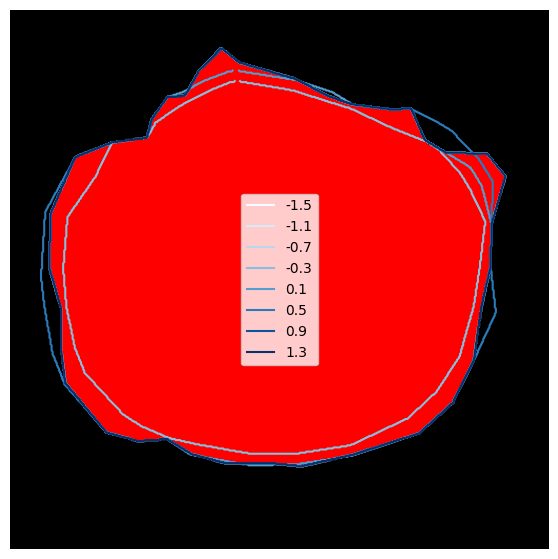

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def is_inside_contour(point, contours):
  point = point.astype(float)
  for contour in contours:
    if cv.pointPolygonTest(contour, (point[0], point[1]), False) > 0:
      return True
  return False

def get_simplified_label(label: np.ndarray, dilation_size: int) -> np.ndarray:
  '''
  Gets a simplified version of the label and erodes/dilates it.
  Args:
    label: label image (binary image)
    dilation_size: size of the structuring element for erosion (if <0) or dilation (if >0) (in pixels), if 0, no erosion or dilation is performed
  Returns:
    simplified label image
  '''
  # blur
  label_blur = cv.blur(label, (128, 128))
  # threshold
  thresh = cv.threshold(label_blur, 128, 255, cv.THRESH_BINARY)[1]

  if dilation_size == 0:
    return thresh

  kernel_size = abs(int(round(dilation_size)))
  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))

  if dilation_size < 0:
    return cv.erode(thresh, kernel, iterations=1)
  elif dilation_size > 0:
    return cv.dilate(thresh, kernel, iterations=1)

  return thresh

def get_max_distance(label1: np.ndarray, label2: np.ndarray) -> int:
  '''
  Gets the maximum distance between the contours of two labels.
  Args:
    label1: label image (binary image)
    label2: label image (binary image)
  Returns:
    maximum distance between the contours of the two labels (in pixels)
  '''
  # get contours
  contours1, _ = cv.findContours(label1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  contours2, _ = cv.findContours(label2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  # get contour points
  contour1 = contours1[0].squeeze()
  contour2 = contours2[0].squeeze()
  # get max distance
  max_dist = 0
  for point in contour1:
    print(point)
    point = point.astype(float)
    dist = cv.pointPolygonTest(contour2, tuple(point), True)
    dist = abs(dist)
    if dist > max_dist:
      max_dist = dist
  return max_dist

def get_initial_label_for_dilation(label, max_dist):
  kernel = np.ones((int(max_dist) * 2, int(max_dist) * 2), np.uint8)
  return cv.erode(label, kernel, iterations=1)

def get_contour_polygon_points(label):
  contour = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0][0].squeeze()
  epsilon = 0.001 * cv.arcLength(contour, True)
  approx = cv.approxPolyDP(contour, epsilon, True)
  points = []
  for point in approx:
    points.append(point[0])
  return np.array(points)


def make_error_label(gt_label, simplified_label, percent_error):
  points = get_contour_polygon_points(gt_label)

  # label points as groups of 1s or 0s
  point_groups = []
  group = []

  simplified_contours, _ = cv.findContours(simplified_label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  point_above_contour = [is_inside_contour(p, simplified_contours) for p in points]

  for i, point in enumerate(points):
    if i == 0:
      group.append(point)
    else:
      if point_above_contour[i] == point_above_contour[i - 1]:
        group.append(point)
      else:
        point_groups.append(group)
        group = [point]

  # choose random groups to pull towards contour
  n_groups_to_pull = round(percent_error * len(point_groups))
  random_group_idxs = np.random.randint(len(point_groups), size=n_groups_to_pull)

  new_points = np.array(points)
  all_contour_points = simplified_contours[0].squeeze()

  # pull chosen groups towards contour
  for i, point in enumerate(points):
    # check if point is in random group
    in_group = False
    for group_idx in random_group_idxs:
      if np.sum(point == point_groups[group_idx]) > 0:
        in_group = True
        break
    
    if not in_group:
      continue

    # get closest point on error contour
    closest_point = None
    min_dist = float('inf')
    for contour_point in all_contour_points:
      dist = np.linalg.norm(contour_point - point)
      if dist < min_dist:
        min_dist = dist
        closest_point = contour_point

    new_points[i] = closest_point
  
  # draw contour from new_points
  contour = np.array([new_points], dtype=np.int32)
  error_label = np.zeros(gt_label.shape, np.uint8)
  error_label = cv.drawContours(error_label, contour, -1, 255, 2)

  return error_label

fn_im = 'test_imgs/ISIC_0000264.jpg'
fn_anno = 'test_imgs/ISIC_0000264_segmentation.png'

label = cv.imread(fn_anno, cv.IMREAD_GRAYSCALE)
label = cv.resize(label, (512, 512), interpolation=cv.INTER_NEAREST)
simplified_label = get_simplified_label(label, 0)
max_dist = get_max_distance(label, simplified_label)

ratios = np.arange(-1.5, 1.5, 0.4)

labels_for_ratios = []
for ratio in ratios:
  dilation = round(ratio * max_dist * 2)
  current_label = get_simplified_label(label, dilation)
  error_label = make_error_label(label, current_label, 0.5)
  labels_for_ratios.append(error_label)

# ratio colors for plotting
colors = plt.cm.Blues(np.linspace(0, 1, len(ratios)))

# plot
fig, ax = plt.subplots(figsize=(7, 7))
label_rgb = cv.cvtColor(label, cv.COLOR_GRAY2RGB)
label_rgb[label == 255] = (255, 0, 0)
ax.imshow(label_rgb)

for i, ratio in enumerate(ratios):
  contours, _ = cv.findContours(labels_for_ratios[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  contour = contours[0].squeeze()
  ax.plot(contour[:, 0], contour[:, 1], color=colors[i], linewidth=1.5, label=round(ratio, 2))
ax.legend()
ax.axis('off')

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from data.segmentation_dataset import LesionSegmentationDataset

dataset = LesionSegmentationDataset('train', 'isic')
contour_len = []

for (img, label) in dataset:
  label = label['seg'].squeeze()
  label = label * 255
  label = label.detach().cpu().numpy().astype(np.uint8)
  label_contour = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
  contour_len.append(len(label_contour))

In [16]:
contour_point_count = []

for i, (img, label) in enumerate(dataset):
  label = label['seg'].squeeze()
  label = label * 255
  label = label.detach().cpu().numpy().astype(np.uint8)
  label_contour = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
  # get contour of largest area
  contour = max(label_contour, key=cv.contourArea)
  contour_point_count.append(len(contour))

(array([ 1.,  2.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  2.,
         1.,  2.,  0.,  4.,  1.,  1.,  2.,  2.,  5.,  1.,  6.,  1.,  7.,
        17.,  0., 13.,  1., 12.,  2., 20.,  2.,  7., 15.,  5., 16.,  6.,
        25.,  2., 11., 18.,  4., 28., 11., 16.,  8., 18.,  4., 29., 19.,
         4., 20.,  9., 27., 11., 14.,  5., 19., 20.,  2., 15.,  9., 21.,
         8., 19.,  5., 26., 28.,  3., 30., 13., 23.,  2., 25., 35.,  8.,
        29., 13., 22., 12., 21.,  5., 30., 24.,  5., 29., 16., 22., 12.,
        20.,  5., 28., 22.,  8., 24., 10.,  5.,  9., 18.,  8., 22., 30.,
         8., 17.,  9., 18., 13., 29., 20.,  3., 24., 14., 17., 10., 28.,
         4., 15., 24.,  6., 20., 11., 11.,  7., 19.,  8., 13., 19.,  4.,
        25., 10., 20., 13., 22.,  7., 27., 24.,  9., 21., 12., 14.,  7.,
        20., 23.,  4., 23., 13., 14., 13., 18.,  8., 16., 29.,  5., 12.,
        10., 14.,  9., 20.,  3., 15., 23.,  3., 13.,  9., 10., 14., 18.,
         8., 14., 20.,  5., 17.,  9., 11., 12., 19.

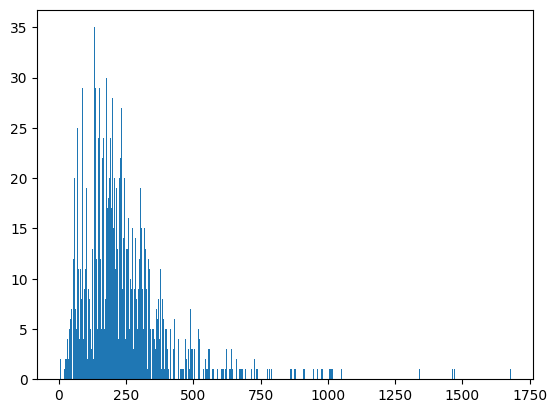

In [19]:
# plot histogram
plt.hist(contour_point_count, bins=1000)

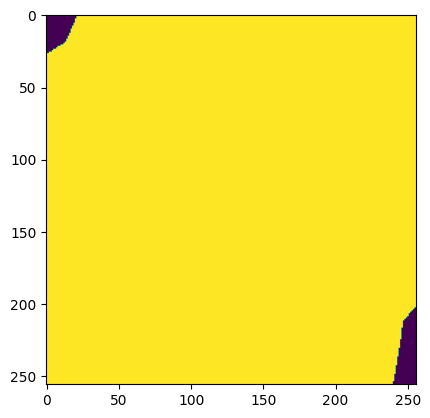

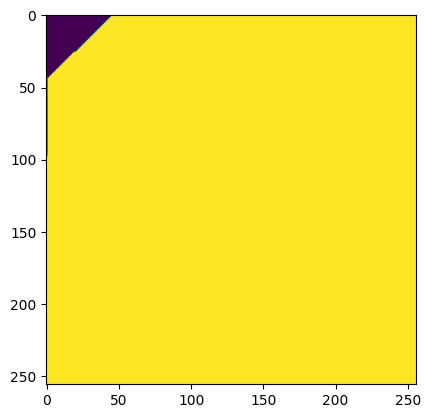

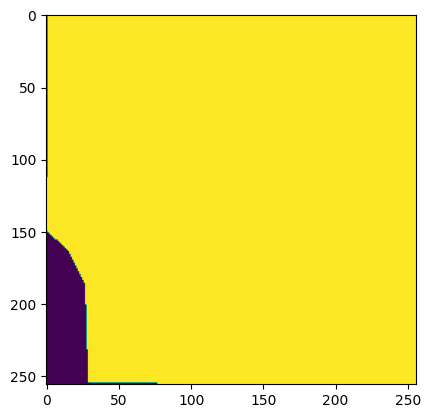

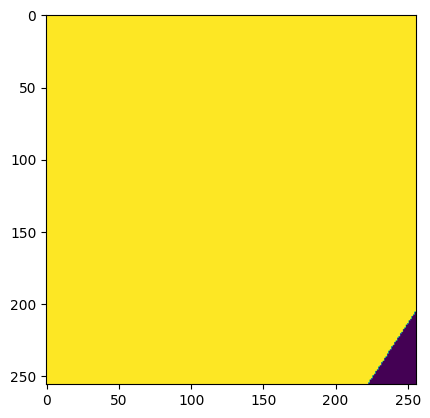

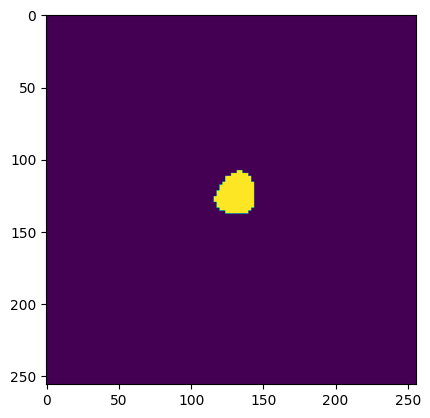

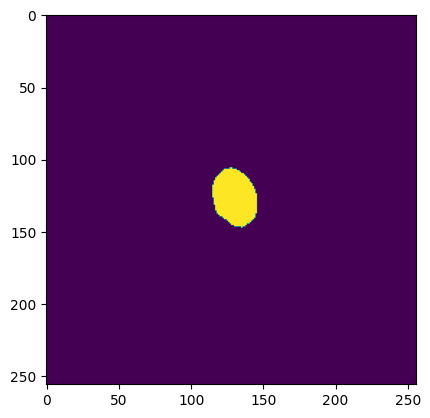

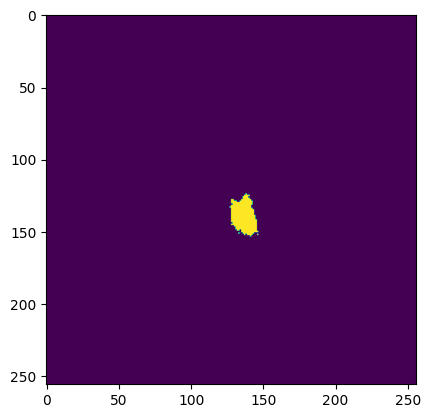

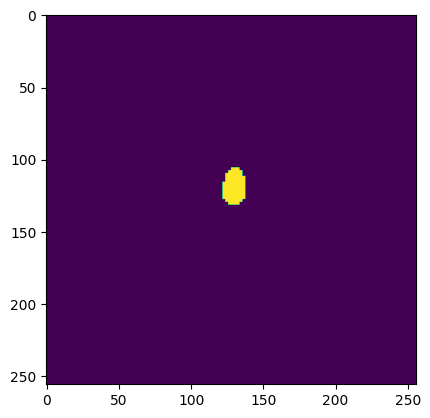

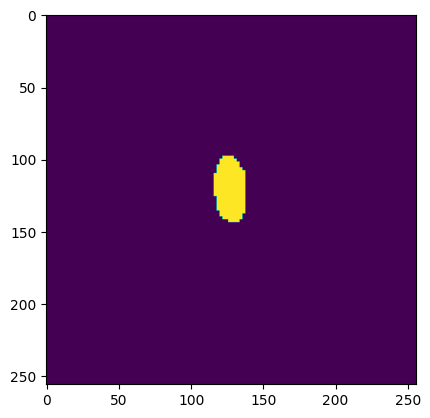

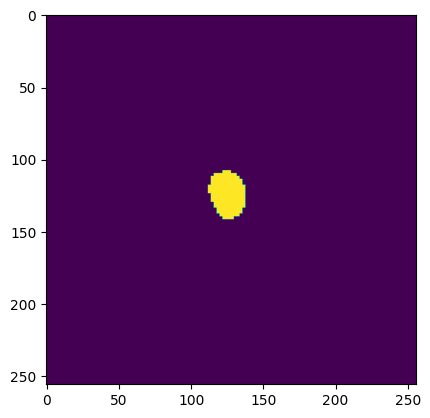

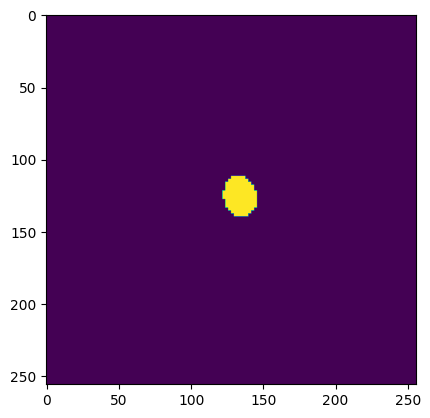

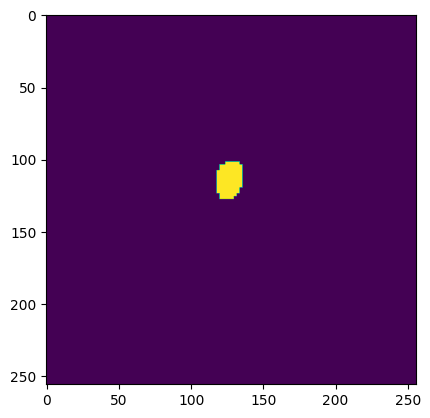

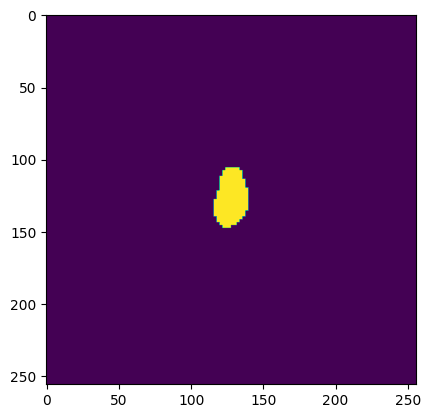

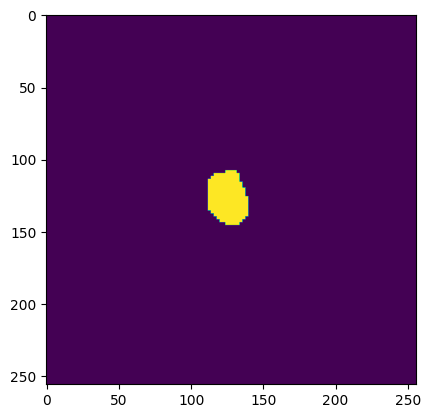

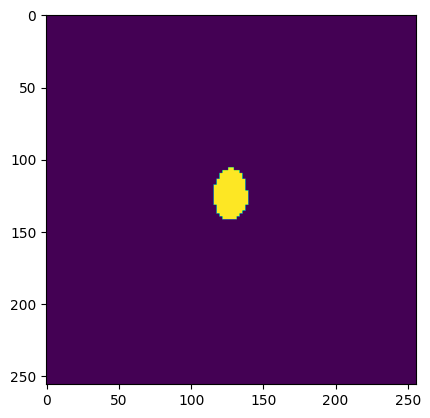

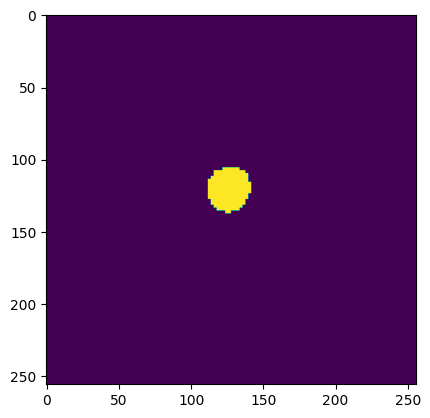

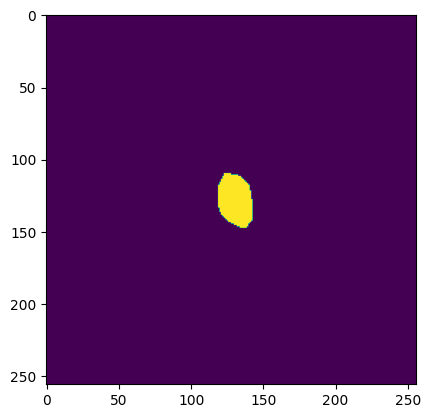

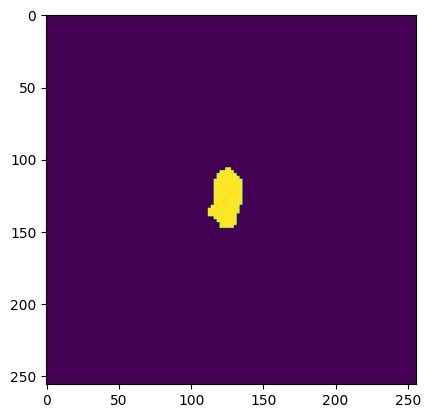

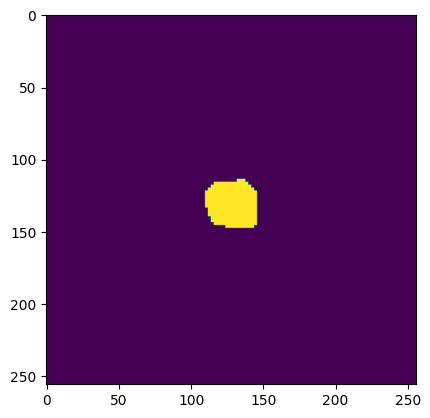

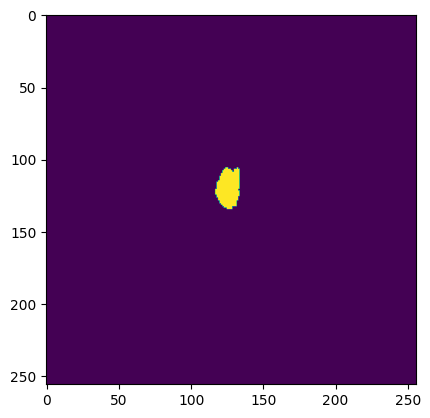

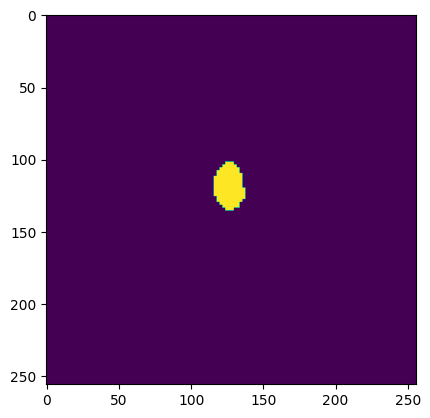

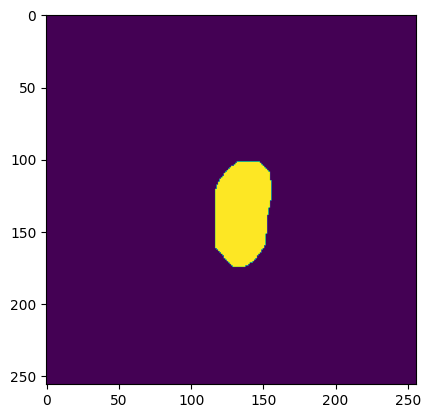

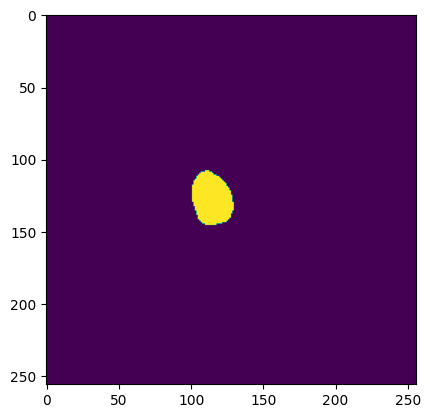

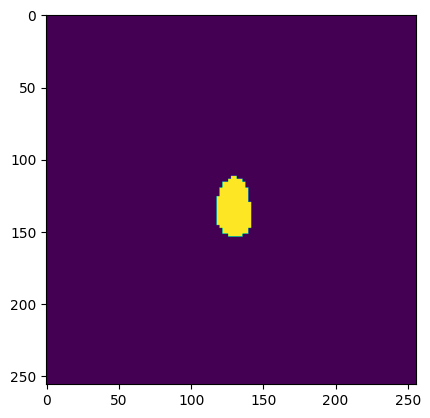

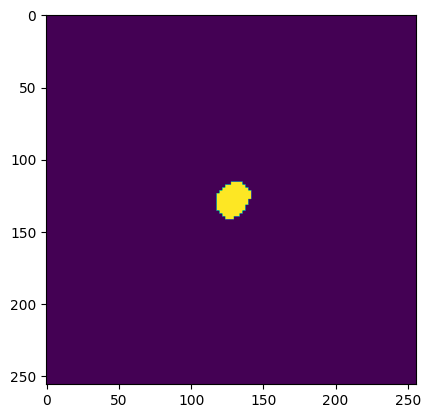

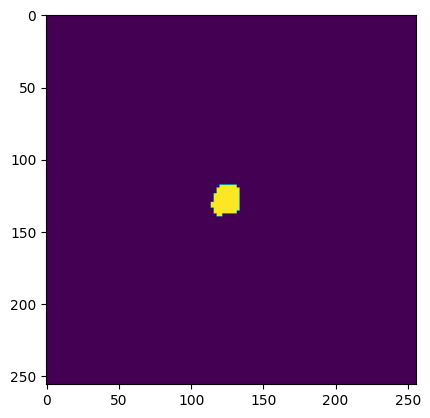

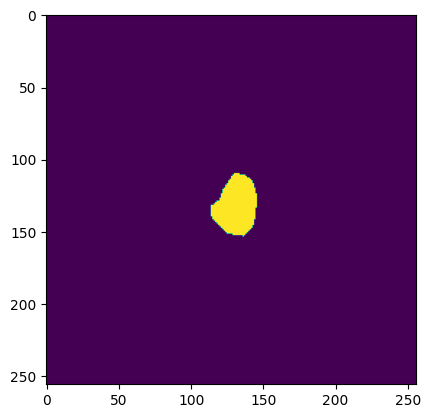

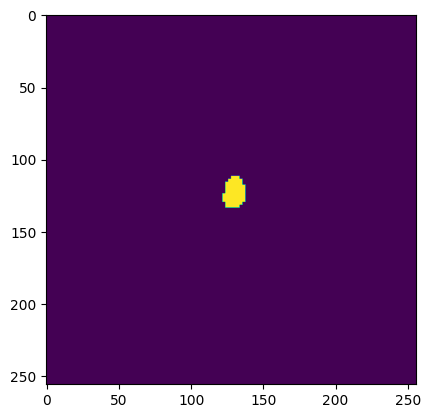

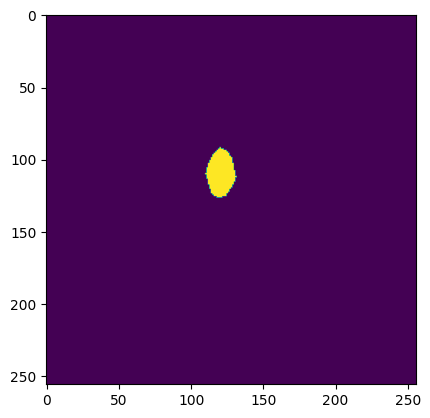

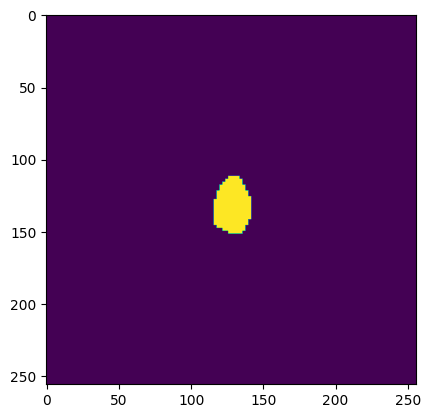

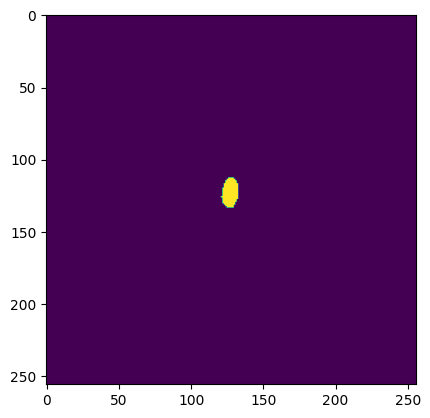

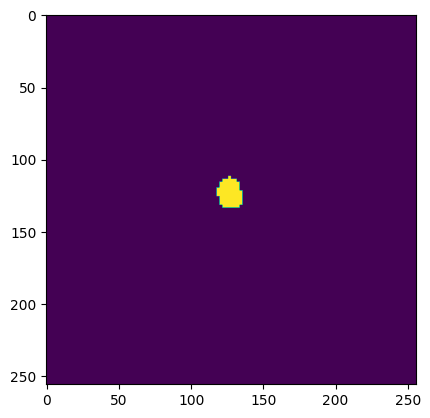

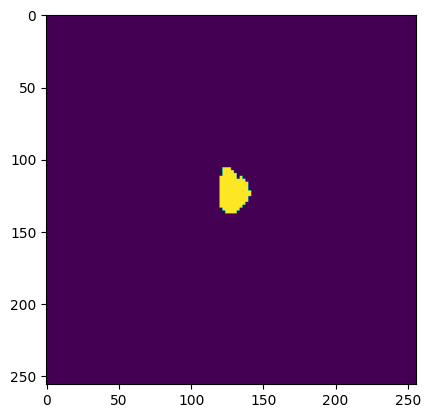

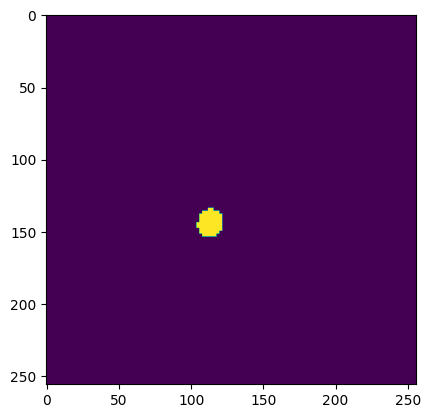

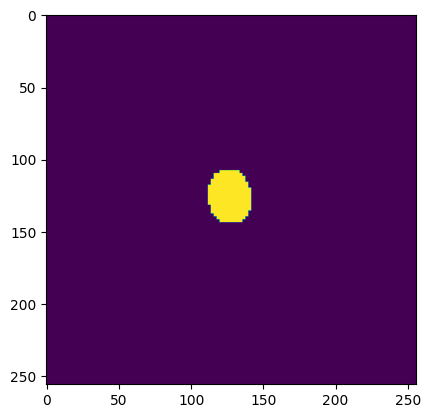

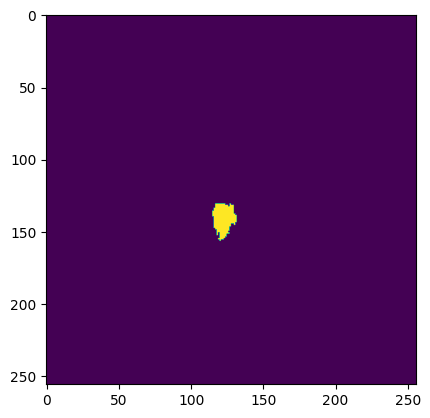

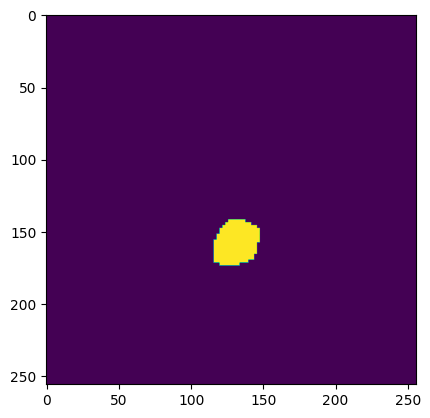

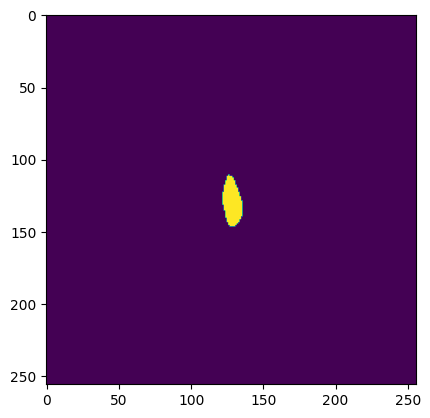

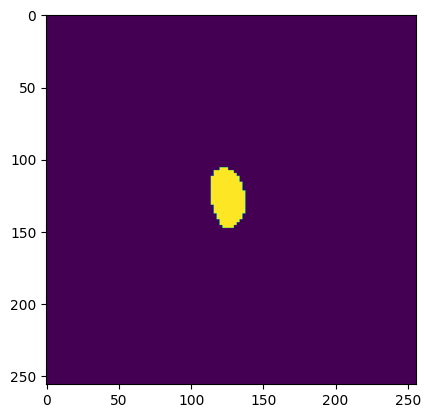

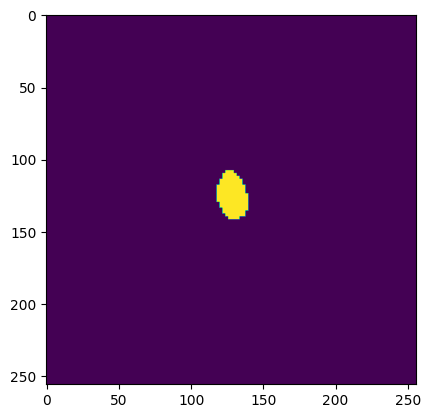

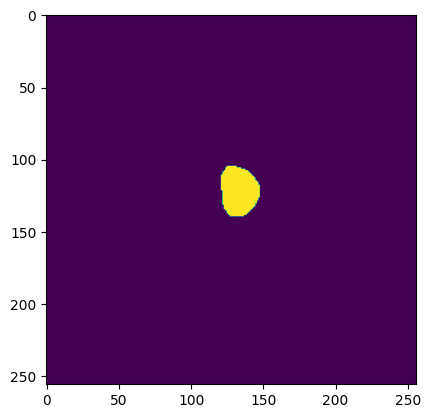

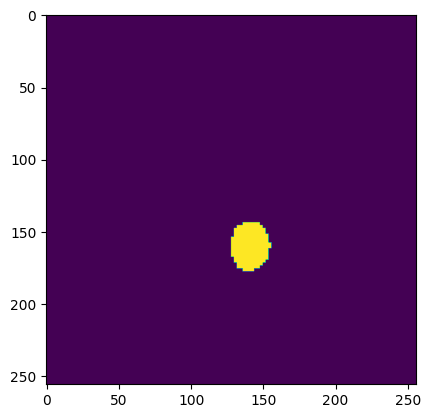

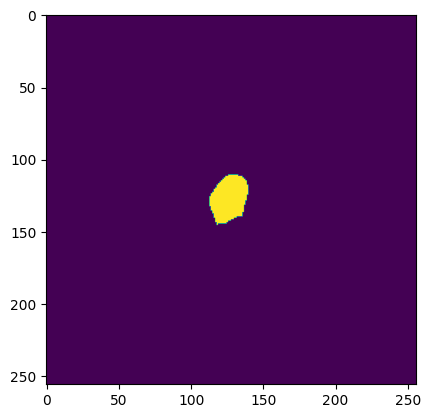

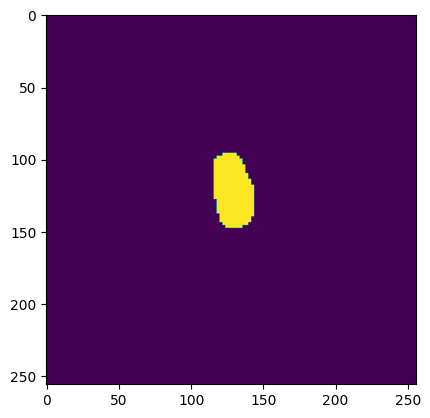

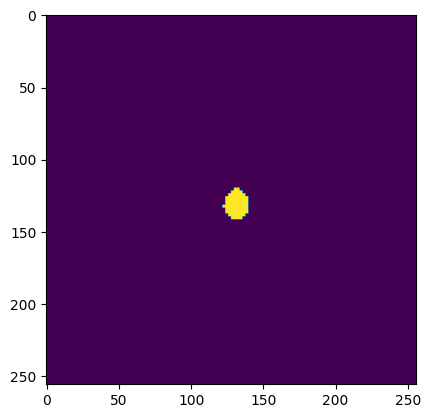

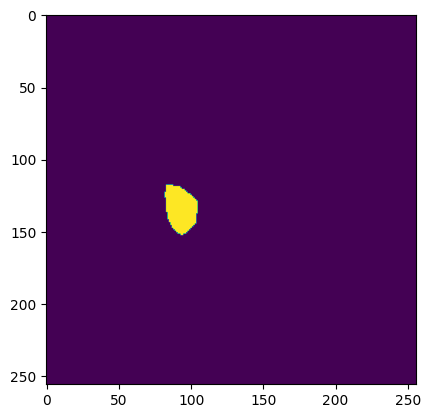

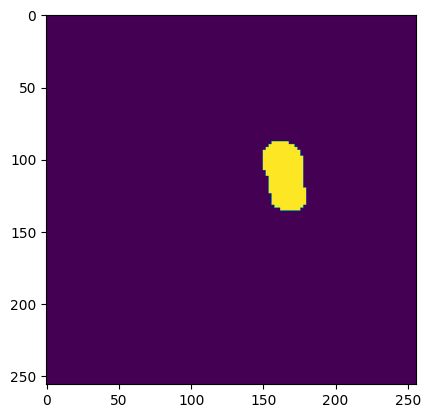

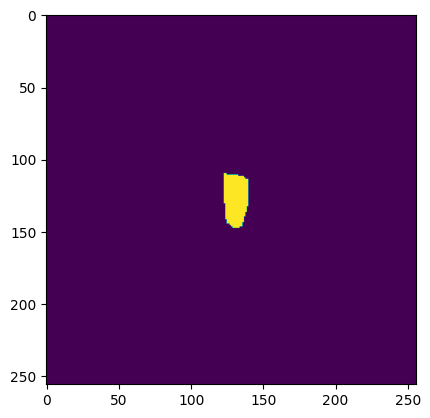

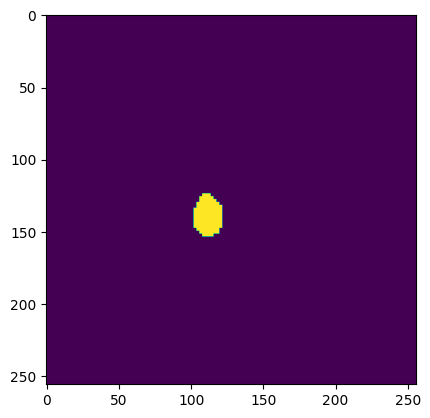

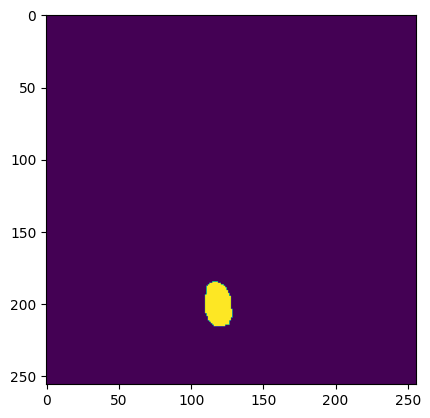

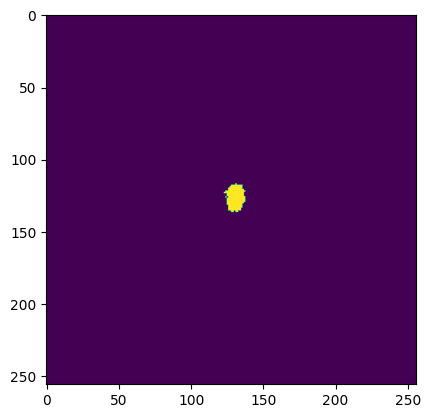

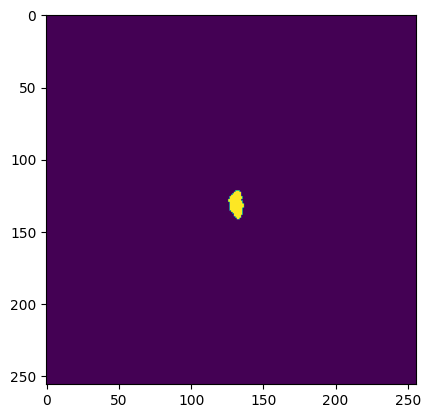

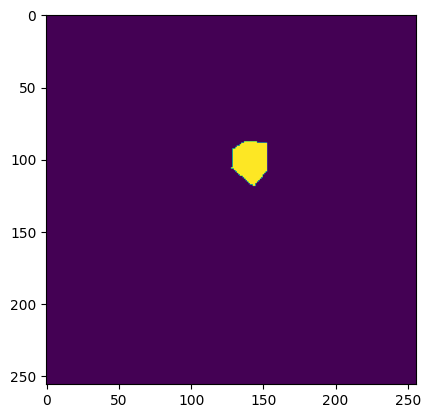

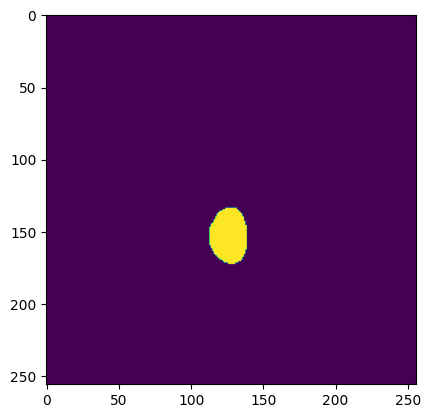

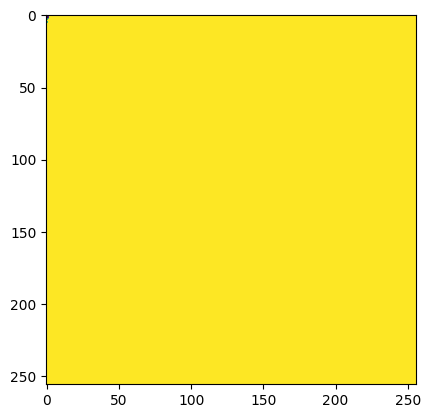

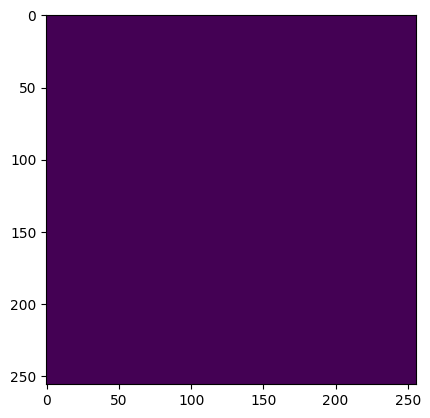

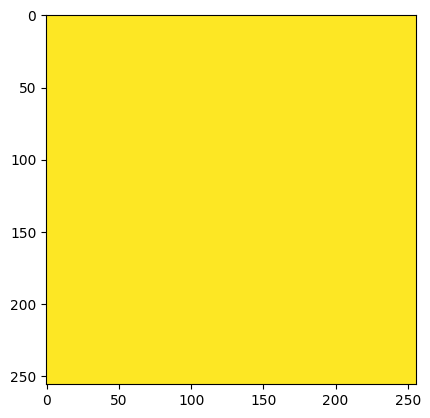

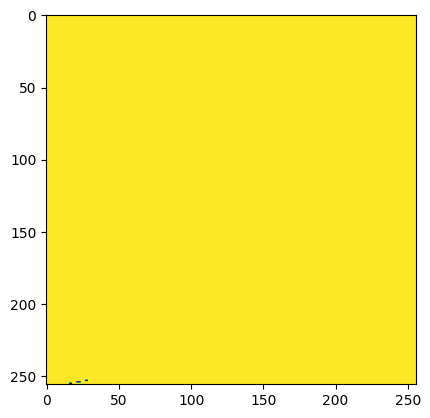

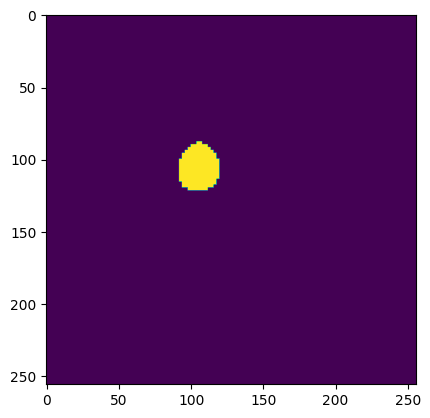

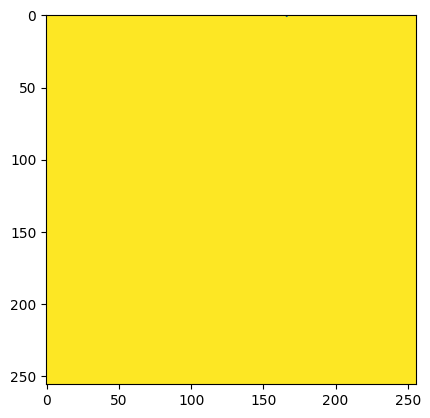

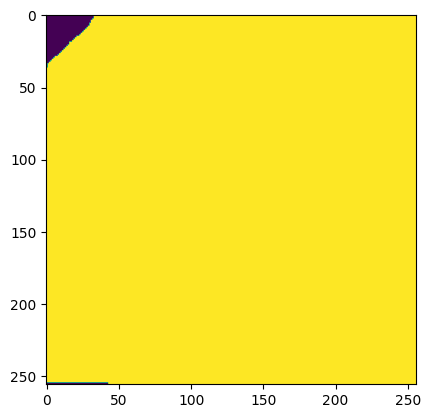

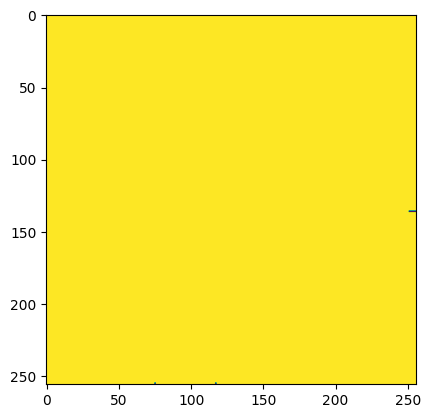

In [20]:
# plot contours with point count below n
n = 50

for i, (img, label) in enumerate(dataset):
  label = label['seg'].squeeze()
  label = label * 255
  label = label.detach().cpu().numpy().astype(np.uint8)
  label_contour = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
  # get contour of largest area
  contour = max(label_contour, key=cv.contourArea)
  if len(contour) < n:
    plt.imshow(label)
    plt.show()